In [4]:
import os

import pandas as pd
import numpy as np
import scipy

from datetime import datetime
from tqdm import tqdm
import random

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import implicit

import warnings
warnings.filterwarnings("ignore")

In [5]:
seed = 42

random.seed(seed)
np.random.seed(seed)

In [6]:
train_data_dir = '/opt/ml/level2-movie-recommendation-level2-recsys-13/practice/T3080'
train = pd.read_csv(os.path.join(train_data_dir, 'train_set.csv'))
val = pd.read_csv(os.path.join(train_data_dir, 'val_set.csv'))


In [4]:
title = pd.read_csv('/opt/ml/input/data/train/titles.tsv', sep='\t')
rating = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv')

In [5]:
train['view'] = 1

In [6]:
train

,user,item,time,view
0,11,4643,1230782529,1
1,11,170,1230782534,1
2,11,531,1230782539,1
3,11,616,1230782542,1
4,11,2140,1230782563,1
...,...,...,...,...
4997666,138493,44022,1260209449,1
4997667,138493,4958,1260209482,1
4997668,138493,68319,1260209720,1
4997669,138493,40819,1260209726,1


In [7]:
pivot = pd.pivot_table(data=train, values='view', index='user', columns='item').fillna(0)
pivot

item,1,2,3,4,5,6,7,8,9,10,...,116823,117176,117533,117881,118696,118700,118900,118997,119141,119145
user,,,,,,,,,,,,,,,,,,,,,
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138473,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:

import scipy

als_model = implicit.als.AlternatingLeastSquares(factors=200, regularization=40, iterations=50)

In [9]:
preference_matrix_csr = scipy.sparse.csr_matrix(pivot)

In [12]:
pivot.columns

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            116823, 117176, 117533, 117881, 118696, 118700, 118900, 118997,
            119141, 119145],
           dtype='int64', name='item', length=6807)

In [10]:
als_model.fit(preference_matrix_csr)

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
als_model_df = pd.DataFrame(np.matmul(als_model.user_factors, als_model.item_factors.T), columns=pivot.columns, index=pivot.index)
als_model_df

item,1,2,3,4,5,6,7,8,9,10,...,116823,117176,117533,117881,118696,118700,118900,118997,119141,119145
user,,,,,,,,,,,,,,,,,,,,,
11,0.972759,0.579631,0.020178,0.001408,0.056648,-0.042207,0.042059,0.018812,0.018809,0.270119,...,-0.000350,-0.005209,0.001000,-0.001858,0.001269,-0.000019,-0.001712,0.000863,0.003116,-0.002609
14,0.843908,0.153951,0.065044,0.000864,0.093623,0.039948,0.150159,0.011271,-0.004102,0.042044,...,0.001837,0.004234,-0.000523,0.001320,-0.006612,-0.001384,0.000568,0.007571,-0.003048,-0.000702
18,0.062710,-0.004516,0.011828,-0.001033,-0.002387,-0.053781,-0.002077,0.000442,0.000453,-0.004788,...,-0.004870,0.000026,-0.000423,0.001451,-0.001311,-0.000603,-0.000650,-0.002455,-0.001359,-0.001591
25,0.331434,0.169394,0.048716,0.000547,0.008503,0.116433,0.009030,0.002010,-0.000122,0.123257,...,0.001768,0.000644,-0.002080,-0.001716,0.003058,0.000099,-0.000489,-0.000298,0.000428,0.000893
31,0.112256,0.062140,-0.004972,-0.000717,-0.003893,-0.012646,0.010146,0.001865,0.002506,-0.059894,...,0.064945,0.005334,-0.002575,-0.000833,0.076179,-0.001362,-0.002316,0.012757,0.013180,0.015016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138473,0.398975,0.054851,-0.003428,0.000292,0.004382,0.107926,0.001109,0.001733,-0.000831,-0.045218,...,0.006298,0.002901,-0.000660,0.000660,0.001456,0.002016,0.001970,0.001911,0.002082,0.000743
138475,0.003952,-0.061414,-0.001795,0.000672,0.004858,0.042833,-0.008992,-0.002652,-0.000208,0.008304,...,-0.005305,-0.005667,0.000513,0.000427,0.004311,-0.003998,0.000838,0.003944,-0.004182,-0.001569
138486,0.556726,0.427470,0.042199,-0.000034,0.013312,0.042590,-0.022538,0.002234,0.007098,0.231230,...,-0.001259,0.003147,0.000270,0.001273,-0.007185,0.002183,0.000634,0.001839,0.001742,-0.000839


In [14]:
als_model_df_final = als_model_df - pivot * 1000
als_model_df_final

item,1,2,3,4,5,6,7,8,9,10,...,116823,117176,117533,117881,118696,118700,118900,118997,119141,119145
user,,,,,,,,,,,,,,,,,,,,,
11,-999.027241,0.579631,0.020178,0.001408,0.056648,-0.042207,0.042059,0.018812,0.018809,0.270119,...,-0.000350,-0.005209,0.001000,-0.001858,0.001269,-0.000019,-0.001712,0.000863,0.003116,-0.002609
14,-999.156092,0.153951,0.065044,0.000864,0.093623,0.039948,-999.849841,0.011271,-0.004102,0.042044,...,0.001837,0.004234,-0.000523,0.001320,-0.006612,-0.001384,0.000568,0.007571,-0.003048,-0.000702
18,0.062710,-0.004516,0.011828,-0.001033,-0.002387,-0.053781,-0.002077,0.000442,0.000453,-0.004788,...,-0.004870,0.000026,-0.000423,0.001451,-0.001311,-0.000603,-0.000650,-0.002455,-0.001359,-0.001591
25,0.331434,0.169394,0.048716,0.000547,0.008503,0.116433,0.009030,0.002010,-0.000122,0.123257,...,0.001768,0.000644,-0.002080,-0.001716,0.003058,0.000099,-0.000489,-0.000298,0.000428,0.000893
31,0.112256,0.062140,-0.004972,-0.000717,-0.003893,-0.012646,0.010146,0.001865,0.002506,-0.059894,...,0.064945,0.005334,-0.002575,-0.000833,-999.923821,-0.001362,-0.002316,0.012757,0.013180,0.015016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138473,-999.601025,0.054851,-0.003428,0.000292,0.004382,0.107926,0.001109,0.001733,-0.000831,-0.045218,...,0.006298,0.002901,-0.000660,0.000660,0.001456,0.002016,0.001970,0.001911,0.002082,0.000743
138475,0.003952,-0.061414,-0.001795,0.000672,0.004858,0.042833,-0.008992,-0.002652,-0.000208,0.008304,...,-0.005305,-0.005667,0.000513,0.000427,0.004311,-0.003998,0.000838,0.003944,-0.004182,-0.001569
138486,0.556726,0.427470,0.042199,-0.000034,0.013312,0.042590,-0.022538,0.002234,0.007098,0.231230,...,-0.001259,0.003147,0.000270,0.001273,-0.007185,0.002183,0.000634,0.001839,0.001742,-0.000839


In [28]:
result = np.argpartition(als_model_df_final, -5).iloc[:, -5:]
result

item,118700,118900,118997,119141,119145
user,,,,,
11,3663,2381,2812,4790,1
14,482,554,561,672,648
18,644,179,1281,2309,4064
25,717,1016,3567,360,706
31,3909,1462,5788,5771,3916
...,...,...,...,...,...
138473,77,423,5038,3038,3679
138475,1032,497,2788,471,476
138486,601,3653,3916,237,0


In [31]:
result.values

array([[3663, 2381, 2812, 4790,    1],
       [ 482,  554,  561,  672,  648],
       [ 644,  179, 1281, 2309, 4064],
       ...,
       [ 601, 3653, 3916,  237,    0],
       [1612, 2923, 2135,  670, 2664],
       [1206,  336, 1667, 3679, 1462]])

In [32]:
users, items = list(), list()
item_columns = als_model_df_final.columns
for idx in range(result.shape[0]):
    users.extend([result.index[idx]] * 5)
    for i in result.values[idx]:
        items.append(item_columns[i])
        
test_df = pd.DataFrame(zip(users,items), columns=['user','item'])
# test_df.to_csv("/opt/ml/input/code/experiment/als/most_popular_submission.csv", index=False)

In [48]:
tt = test_df.groupby(['user']).agg({'item':'unique'}).reset_index()
tt

,user,item
0,11,"[7373, 4370, 5349, 40815, 2]"
1,14,"[914, 1028, 1035, 1223, 1198]"
2,18,"[1193, 296, 2324, 4235, 8873]"
3,25,"[1270, 1923, 7153, 597, 1259]"
4,31,"[8360, 2628, 68954, 68358, 8368]"
...,...,...
31355,138473,"[111, 778, 48394, 5952, 7438]"
31356,138475,"[1945, 930, 5291, 903, 908]"
31357,138486,"[1097, 7360, 8368, 377, 1]"
31358,138492,"[2918, 5618, 3897, 1221, 4979]"


In [49]:
vv = val.groupby(['user']).agg({'item':'unique'}).reset_index()
vv

,user,item
0,11,"[586, 2985, 2240, 5349, 52281]"
1,14,"[27706, 1207, 364, 60069, 6979]"
2,18,"[51084, 1211, 608, 1952, 1206]"
3,25,"[2028, 63082, 253, 4027, 261]"
4,31,"[8368, 88744, 7317, 42738, 32031]"
...,...,...
31355,138473,"[64839, 3535, 524, 2232, 2085]"
31356,138475,"[3089, 25940, 3022, 8752, 2204]"
31357,138486,"[1350, 7360, 1, 6874, 33834]"
31358,138492,"[2797, 8784, 2599, 163, 1196]"


In [36]:
user_id = val['user'].unique()

In [66]:
recall = []

In [67]:
for i in tqdm(range(vv.shape[0])):
    recall.append(len(set(vv.iloc[i,1]) & set(tt.iloc[i,1])) / 5)

100%|██████████| 31360/31360 [00:01<00:00, 19816.13it/s]


In [68]:
relt = pd.DataFrame({'user':user_id, 'recall':recall})
relt

,user,recall
0,11,0.2
1,14,0.0
2,18,0.0
3,25,0.0
4,31,0.2
...,...,...
31355,138473,0.0
31356,138475,0.0
31357,138486,0.4
31358,138492,0.0


In [73]:
relt['recall'].values.mean()

0.13239795918367347

In [87]:
zero_user_id = relt[relt['recall'] == 0]['user'].unique()

In [102]:
zero_user_id

array([    14,     18,     25, ..., 138473, 138475, 138492])

In [135]:
ans_user_id = relt[relt['recall'] > 0]['user'].unique()
ans_user_id

array([    11,     31,     43, ..., 138471, 138486, 138493])

In [112]:
user_cnt = rating.groupby(['user'])['item'].agg(['count'])

In [113]:
user_cnt

,count
user,
11,376
14,180
18,77
25,91
31,154
...,...
138473,63
138475,124
138486,137


In [119]:
zero_user_movie_cnt = user_cnt.loc[zero_user_id,'count'].values

In [136]:
ans_user_movie_cnt = user_cnt.loc[ans_user_id,'count'].values

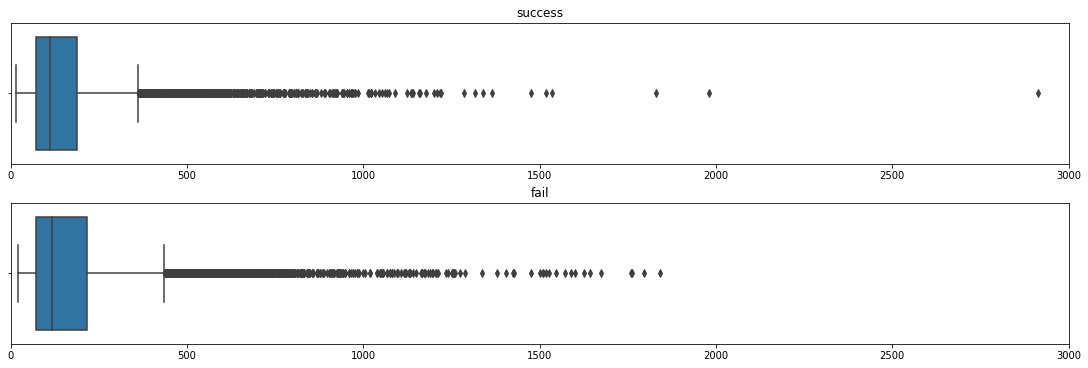

In [142]:
fig, ax = plt.subplots(2,1,figsize=(15,5), constrained_layout=True)

sns.boxplot(x=ans_user_movie_cnt, ax=ax[0])
sns.boxplot(x=zero_user_movie_cnt, ax=ax[1])

# ax.axvline(x=440, color='tab:red', ls='dotted')
ax[0].set_xlim(0, 3000)
ax[0].set_title('success')
ax[1].set_xlim(0, 3000)
ax[1].set_title('fail')

# ax.set_title('user movie count')
plt.show()

In [132]:
sum(zero_user_movie_cnt > 440)

1036

In [134]:
relt[relt['recall'] > 0]

,user,recall
0,11,0.2
4,31,0.2
6,43,0.2
7,50,0.2
9,60,0.4
...,...,...
31349,138457,0.2
31351,138461,0.2
31353,138471,0.4
31357,138486,0.4
